# Lab 1: Linear Regression and Overfitting

### Machine Learning and Pattern Recognition, September 2016

* The lab exercises should be made in groups of two people.
* The deadline is sunday September 25, 23:59.
* Assignment should be sent to your teaching assistant. The subject line of your email should be "\#lab\_lastname1\_lastname2\_lastname3".
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "lab01\_Kingma\_Hu", the attached file should be "lab01\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.
* Make sure we can run your notebook / scripts!

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Refer to last week's lab notes, i.e. http://docs.scipy.org/doc/, if you are unsure about what function to use. There are different correct ways to implement each problem!
* For this lab, your regression solutions should be in closed form, i.e., should not perform iterative gradient-based optimization but find the exact optimum directly.

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import linalg

Populating the interactive namespace from numpy and matplotlib


$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$

## Part 1: Polynomial Regression

### 1.1. Generate sinusoidal data (5 points)
Write a method `gen_sinusoidal(N)` that generates toy data like in fig 1.2 of Bishop's book. The method should have a parameter $N$, and should return $N$-dimensional vectors $\bx$ and $\bt$, where $\bx$ contains evenly spaced values from 0 to (including) 2$\pi$, and the elements $t_i$ of $\bt$ are distributed according to:

$$t_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

where $x_i$ is the $i$-th elements of $\bf{x}$, the mean $\mu_i = sin(x_i)$ and the standard deviation $\sigma = 0.2$.


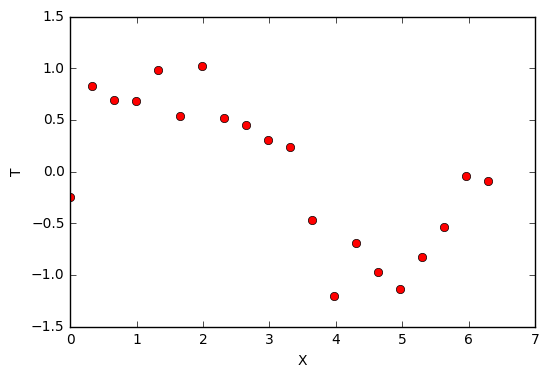

In [2]:
def gen_sinusoidal(N):
    sigma = 0.2
    X = np.linspace(0, 2*np.pi, N)
    T = np.random.normal(np.sin(X),sigma)   
    return X,T

X,T = gen_sinusoidal(20)

# plot
plt.plot(X, T, 'ro')
plt.xlabel('X')
plt.ylabel('T')
plt.show()

### 1.2 Polynomial regression (15 points)

Write a method `fit_polynomial(x, t, M)` that finds the maximum-likelihood solution of an _unregularized_ $M$-th order polynomial for some dataset `x`. The error function to minimize w.r.t. $\bw$ is:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt)$

where $\bPhi$ is the _feature matrix_ (or _design matrix_) as explained in Bishop's book at section 3.1.1, $\bt$ is the vector of target values. Your method should return a vector $\bw$ with the maximum-likelihood parameter estimates. 

In [3]:
# Solving a matrix inverse via two systems of linear equations, using LU decomposition
def compute_inverse(X):
    
    N = X.shape[0]
    
    # compute LU decomposition 
    L,U = sp.linalg.lu(X, permute_l = True)
    
    # NxN identity matrix 
    I = np.identity(N)
    
    # solves two systems of linear equations as follows
    # X = LU
    # L.Z = I
    # U.M = Z, where M = X^-1
    Z = np.array([np.linalg.solve(U,z) for z in [np.linalg.solve(L,I[:,i]) for i in range(0,N)]])
    return Z

def generate_dmatrix(X, M):
    """
    Genereates a design matrix for univariate polynomial regression.
    """
    return np.array([[x**i for i in range(0,M+1)] for x in X])


def fit_polynomial(X,T,M):
    """
    This assumes univariate polynomial regression
    i.e. x is a dataset of n observations - (x1,x2..,xn)
    t is corresponding target value vector.
    """
    # construct design matrix
    phi = generate_dmatrix(X,M)
    
    # closed solution with Gaussian noise assumption
    w = np.linalg.pinv(phi.T.dot(phi)).dot(phi.T.dot(T))
    return w

### 1.3 Plot (5 points)
Sample a dataset with $N=9$, and fit four polynomials with $M \in (0, 1, 3, 9)$.
For each value of $M$, plot the prediction function, along with the data and the original sine function. The resulting figure should look similar to fig 1.4 of the Bishop's book. Note that you can use matplotlib's `plt.pyplot(.)` functionality for creating grids of figures.

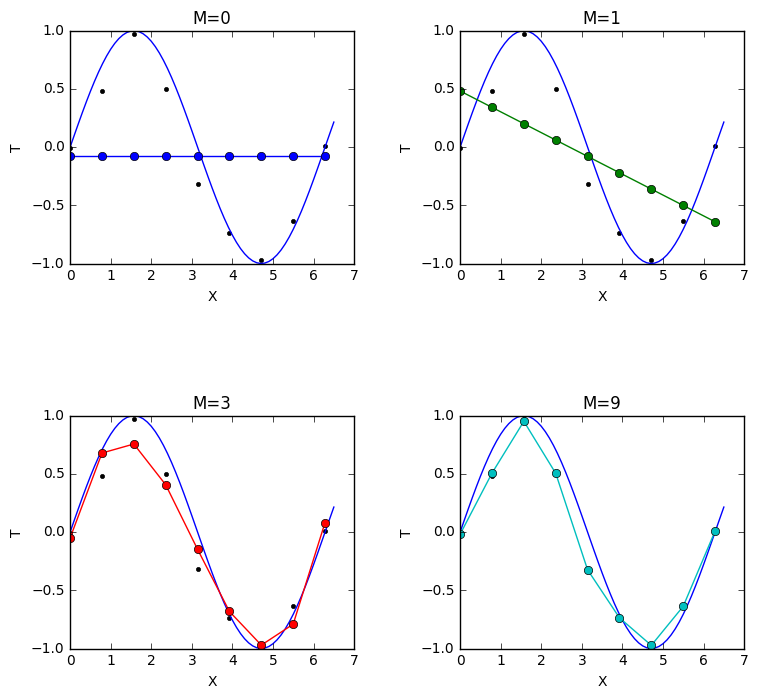

In [4]:
def plot_polynomials():
    X,T = gen_sinusoidal(9)
    M = [0,1,3,9]
    c = ['b','g','r','c']

    fig = plt.figure()

    for i in range(0,len(M)):
        Phi = generate_dmatrix(X,M[i])
        w = fit_polynomial(X,T,M[i])

        d = arange(0.0, 2.1*np.pi, 0.1)

        if i==0:
            ax = fig.add_subplot(221+i)
        else:
            ax = fig.add_subplot(221+i,sharex=ax, sharey=ax)
        ax.plot(X,T,'k.') #data points
        ax.plot(d,np.sin(d),'b-') #sine function
        ax.plot(X, Phi.dot(w), c[i]+'o-') #estimates
        ax.set_title(('M='+str(M[i])))
        ax.set_xlabel('X')
        ax.set_ylabel('T')

    plt.tight_layout()  
    fig.set_figheight(8)
    fig.set_figwidth(8)
    
plot_polynomials()

### 1.4 Regularized linear regression (10 points)

Write a method `fit_polynomial_reg(x, t, M, lamb)` that fits a _regularized_ $M$-th order polynomial to the sinusoidal data, as discussed in the lectures, where `lamb` is the regularization term _lambda_. (Note that 'lambda' cannot be used as a variable name in Python since it has a special meaning). The error function to minimize w.r.t. $\bw$:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt) + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}$

For background, see section 3.1.4 of Bishop's book.

In [5]:
def fit_polynomial_reg(X,T,M,lamb):
    # construct design matrix
    phi = generate_dmatrix(X,M)
    
    #inv = compute_inverse(lamb*np.identity(phi.shape[1])+phi.T.dot(phi))
    inv = np.linalg.pinv(lamb*np.identity(phi.shape[1])+phi.T.dot(phi))
    
    # closed solution with Gaussian noise assumption
    return inv.dot(phi.T.dot(T))






### 1.5 Model selection by cross-validation (10 points)
Use cross-validation to find a good choice of $M$ and $\lambda$, given a dataset of $N=9$ datapoints generated with `gen_sinusoidal(9)`. You should write a function that tries (loops over) a reasonable range of choices of $M$ and $\lambda$, and returns the choice with the best cross-validation error. In this case you can use $K=9$ folds, corresponding to _leave-one-out_ crossvalidation.

You can let $M \in (0, 1, ..., 10)$, and let $\lambda \in (e^{-10}, e^{-9}, ..., e^{0})$.

To get you started, here's a method you can use to generate indices of cross-validation folds.

/home/dana/.local/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Optimal M: 6
Optimal Lambda: e^-7
Min RSME: 0.184480


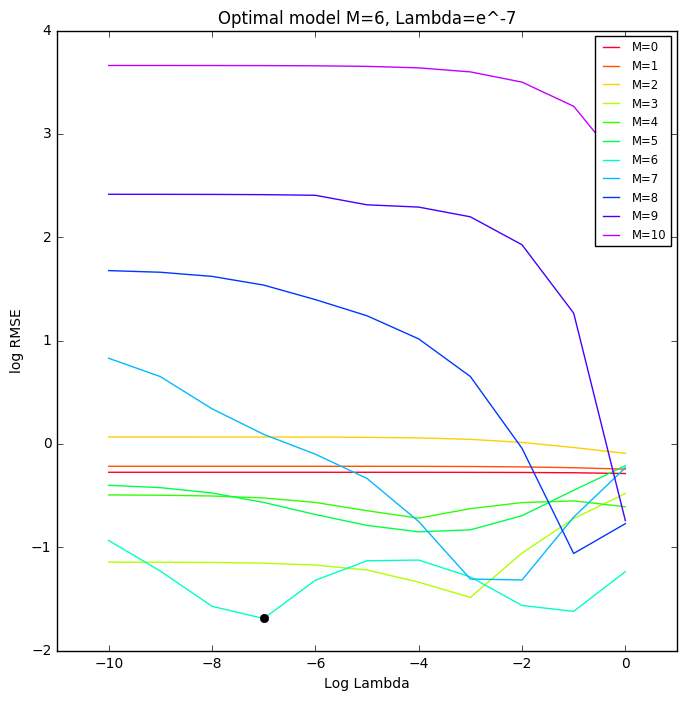

In [6]:
def kfold_indices(N, k):
    all_indices = np.arange(N,dtype=int)
    np.random.shuffle(all_indices)
    idx = np.floor(np.linspace(0,N,k+1))
    train_folds = []
    valid_folds = []
    for fold in range(k):
        valid_indices = all_indices[idx[fold]:idx[fold+1]]
        valid_folds.append(valid_indices)
        train_folds.append(np.setdiff1d(all_indices, valid_indices))
    return train_folds, valid_folds

def mse(T_pred,T):
    return .5*(T_pred-T).T.dot(T_pred-T)

# Returns RMSE
def rmse(T_pred,T):
    return np.sqrt(2*mse(T_pred,T)/len(T))


# Returns the CV prediction error for a single configuration of lambda and m
def model_error(lamb, m, X_tr, T_tr, X_te, T_te):
    
    # train model on training data
    w = fit_polynomial_reg(X_tr,T_tr,m,lamb)
    
    # Design matrix for testing set
    Phi_te = generate_dmatrix(X_te,m)
    return rmse(Phi_te.dot(w),T_te)

def best_cv_model(Lamb, M, K, X, T):

    # generate CV indices
    N = X.shape[0]
    tr_idx,te_idx = kfold_indices(N,K)

    # error matrix
    # row: lambda, columns: M
    E = np.matrix(np.zeros([len(Lamb),len(M)]))

    # Run CV
    for k in range(0,K):

        #training set
        X_tr, T_tr = X[tr_idx[k]], T[tr_idx[k]]

        #testing set
        X_te, T_te = X[te_idx[k]], T[te_idx[k]]

        # add error to matrix error
        E += np.matrix([[model_error(lamb, m, X_tr, T_tr, X_te, T_te) for m in M] for lamb in Lamb])/float(K)

    # get optimal Lambda, M, RMSE
    minL_i,minM_i = np.where(E == E.min())
    min_lambda, min_M, min_rmse = Lamb[minL_i], M[minM_i], E.min()
    print 'Optimal M: %d' % min_M
    print 'Optimal Lambda: e^%d'% log(min_lambda)
    print 'Min RSME: %f' % E.min()    
    
    return min_lambda, min_M, min_rmse, E


def run_cv():
    
    # CV parameters
    N=9
    K=9
    M=np.arange(0,11,1)
    Lamb = np.exp(np.arange(-10,1))
    
    # generate data
    X,T = gen_sinusoidal(N)
    
    min_lambda, min_M, min_rmse, E = best_cv_model(Lamb, M, K, X, T)
    

    # RMSE plot for different values of M
    from matplotlib.font_manager import FontProperties
    fontP = FontProperties()
    fontP.set_size('small')
    fig = plt.figure()
    NUM_COLORS = len(M)
    cm = plt.get_cmap('gist_rainbow')
    ax = fig.add_subplot(111)
    ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    plt.plot(np.log(Lamb),np.log(E),'-')
    plt.legend(['M='+str(m) for m in M],prop = fontP)
    plt.xlabel('Log Lambda')
    plt.xlim([-11,1])
    plt.ylabel('log RMSE')  
    plt.title('Optimal model M=%d, Lambda=e^%d'%(min_M,log(min_lambda)))
    plot(np.log(min_lambda),log(min_rmse),'ko')
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.show()

    # Extra
    # Contour plot
#     plt.figure()
#     x_mesh, y_mesh = np.meshgrid(log(Lamb), M)
#     cp = plt.contourf(x_mesh, y_mesh, log(E))
#     cbar = plt.colorbar(cp)
#     plot(np.log(min_lambda),min_M,'w*')
#     plt.title('Optimal model M=%d, Lambda=e^%d'%(min_M,log(min_lambda)))
#     plt.xlabel('Log Lambda')
#     plt.ylabel('M')
    
run_cv()

Create a comprehensible plot of the cross-validation error for each choice of $M$ and $\lambda$. Highlight the best choice. 

_Question_: Explain over-fitting and underfitting, illuminated by your plot. Explain the relationship with model bias and model variance.

Answer: We can see that with models such as M={10,9,8,7}, the CV RMSE decreases as the lambda increases. Therefore by penalizing large values in the the coefficients vector (w), the cross validation error decreased. Large coefficients create a very sensitive model, where small changes in X can result in very large changes in T (high variance). This is called overfitting, where the function is fitting the noise of the data. In this case, high-dimensional models overfit easily given that we have a small number of data points (N=9). On the other hand, we can see that simpler models with M={0,1,2,3} have a relatively stable RMSE error. This is due to the fact that the model is underfitting the data, therefore changes in X result in small changes in T (low variance). However, the model is systematically erroneous in its predictions across different values of lambda, and therefore has high bias. High bias and low variance corresponds to underfitting, and is often encountered when M is small or lambda is very large. High variance and low bias correponds to overfitting and is often encountered when M is large and lambda is small.

### 1.6 Plot best cross-validated fit (5 points)

For some dataset with $N = 9$, plot the model with the optimal $M$ and $\lambda$ according to the cross-validation error, using the method you just wrote. Let the plot make clear which $M$ and $\lambda$ were found.

/home/dana/.local/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Optimal M: 5
Optimal Lambda: e^-2
Min RSME: 0.090053


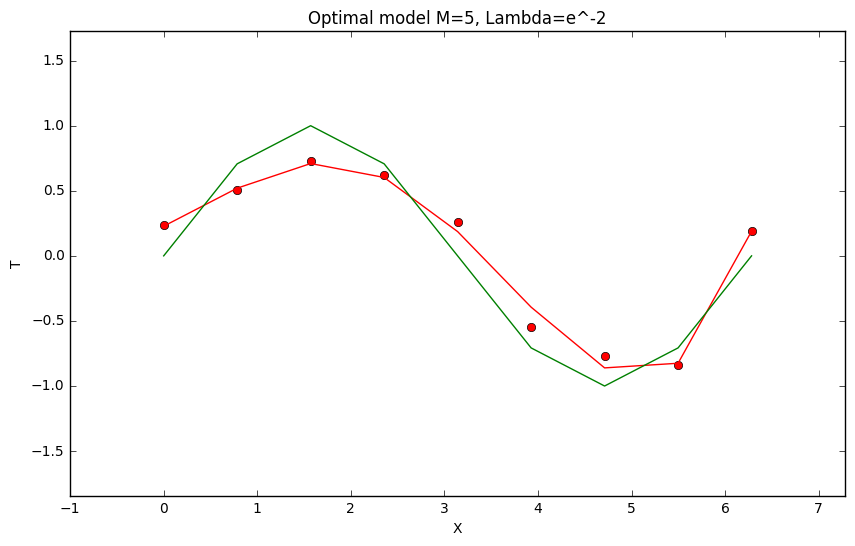

In [7]:
def plot_bestcrossv_fit():
    # CV parameters
    N=9
    K=9
    M=np.arange(0,11,1)
    Lamb = np.exp(np.arange(-10,1))
    
    # generate data
    X,T = gen_sinusoidal(N)
    
    min_lambda, min_M, min_rmse, E = best_cv_model(Lamb, M, K, X, T)
    
    design_m = generate_dmatrix(X, min_M)
    optimum_w = fit_polynomial_reg(X, T, min_M, min_lambda)

    y = np.dot(design_m,optimum_w)

    plt.figure(figsize=(10,6))
    plt.plot(X,T, 'ro')
    plt.plot(X,y, 'r')
    plt.plot(X,np.sin(X), 'g')
    plt.xlabel('X')
    plt.ylabel('T')
    plt.title('Optimal model M=%d, Lambda=e^%d'%(min_M,log(min_lambda)))
    plt.axis([np.amin(X)-1, np.amax(X)+1, np.amin(T)-1, np.amax(T)+1])
    plt.show()
    
plot_bestcrossv_fit()

## Part 2: Bayesian Linear (Polynomial) Regression

### 2.1 Sinusoidal data 2 (5 points)

Write a function `gen_sinusoidal2(N)` that behaves identically to `gen_sinusoidal(N)` except that the generated values $x_i$ are not linearly spaced, but drawn from a uniform distribution between $0$ and $2 \pi$.

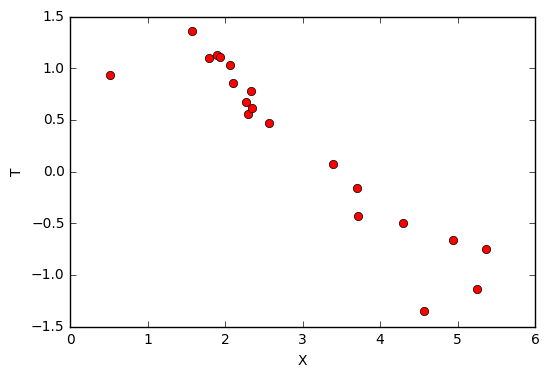

In [8]:
def gen_sinusoidal2(N):
    sigma=0.2
    X = np.random.uniform(0, np.pi * 2, N)
    T = np.random.normal(np.sin(X),sigma)
    return X,T

X,T = gen_sinusoidal2(20)

# plot
plt.plot(X, T, 'ro')
plt.xlabel('X')
plt.ylabel('T')
plt.show()

### 2.2 Compute Posterior (15 points)

You're going to implement a Bayesian linear regression model, and fit it to the sinusoidal data. Your regression model has a zero-mean isotropic Gaussian prior over the parameters, governed by a single (scalar) precision parameter $\alpha$, i.e.:

$$p(\bw \;|\; \alpha) = \mathcal{N}(\bw \;|\; 0, \alpha^{-1} \bI)$$

The covariance and mean of the posterior are given by:

$$\bS_N= \left( \alpha \bI + \beta \bPhi^T \bPhi \right)^{-1} $$
$$\bm_N = \beta\; \bS_N \bPhi^T \bt$$

where $\alpha$ is the precision of the predictive distribution, and $\beta$ is the noise precision. 
See MLPR chapter 3.3 for background.

Write a method `fit_polynomial_bayes(x, t, M, alpha, beta)` that returns the mean $\bm_N$ and covariance $\bS_N$ of the posterior for a $M$-th order polynomial, given a dataset, where `x`, `t` and `M` have the same meaning as in question 1.2.

In [9]:
def fit_polynomial_bayes(x, t, M, alpha, beta):
    # Generate matrix and I
    design_matrix = generate_dmatrix(x, M)
    I = np.identity(design_matrix.shape[1])
    
    # Compute cov and mean.
    covariance = np.linalg.pinv(((alpha * I) + (beta * (design_matrix.T.dot(design_matrix)))))
    mean = beta * covariance.dot(design_matrix.T.dot(t))
    
    return mean, covariance

### 2.3 Prediction (10 points)

The predictive distribution of Bayesian linear regression is:

$$ p(t \;|\; \bx, \bt, \alpha, \beta) = \mathcal{N}(t \;|\; \bm_N^T \phi(\bx), \sigma_N^2(\bx))$$

$$ \sigma_N^2 = \frac{1}{\beta} + \phi(\bx)^T \bS_N \phi(\bx) $$

where $\phi(\bx)$ are the computed features for a new datapoint $\bx$, and $t$ is the predicted variable for datapoint $\bx$. 

Write a function that `predict_polynomial_bayes(x, m, S, beta)` that returns the predictive mean and variance given a new datapoint `x`, posterior mean `m`, posterior variance `S` and a choice of model variance `beta`.

In [10]:
def predict_polynomial_bayes(x, m, S, beta):
    # As x is given only as a datapoint, i.e.: x = 3, we need to actually
    # compute the linear function of x as a linear combination of w and x.
    # now the order of the polynomial is not given but we can infer it from 
    # the size of m - 1 = the number of ws necessary = the order of the polynomial.
    phi_x = generate_dmatrix(np.array([x]), len(m) - 1).T
        
    # Compute the predictive variance
    predictive_variance = (1. / beta) + (np.dot(phi_x.T, S).dot(phi_x))
    
    # Compute predictive mean
    predictive_mean = np.dot(m.T, phi_x)
    
    return predictive_mean.item(), predictive_variance.item()

### 2.4 Plot predictive distribution (10 points)

a) (5 points) Generate 7 datapoints with `gen_sinusoidal2(7)`. Compute the posterior mean and covariance for a Bayesian polynomial regression model with $M=5$, $\alpha=\frac{1}{2}$ and $\beta=\frac{1}{0.2^2}$.
Plot the Bayesian predictive distribution, where you plot (for $x$ between 0 and $2 \pi$) $t$'s predictive mean and a 1-sigma predictive variance using `plt.fill_between(..., alpha=0.1)` (the alpha argument induces transparency).

Include the datapoints in your plot.

b) (5 points) For a second plot, draw 100 samples from the parameters' posterior distribution. Each of these samples is a certain choice of parameters for 5-th order polynomial regression. 
Display each of these 100 polynomials.

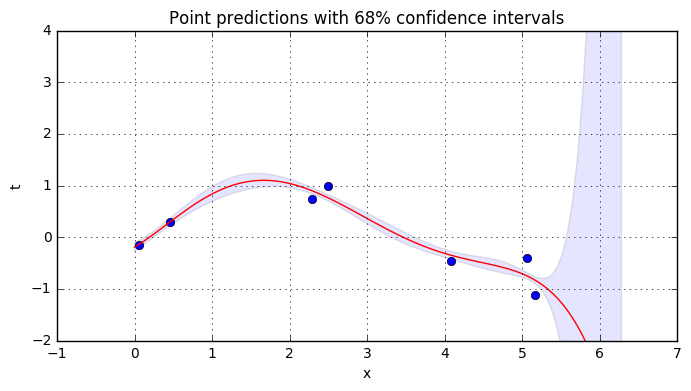

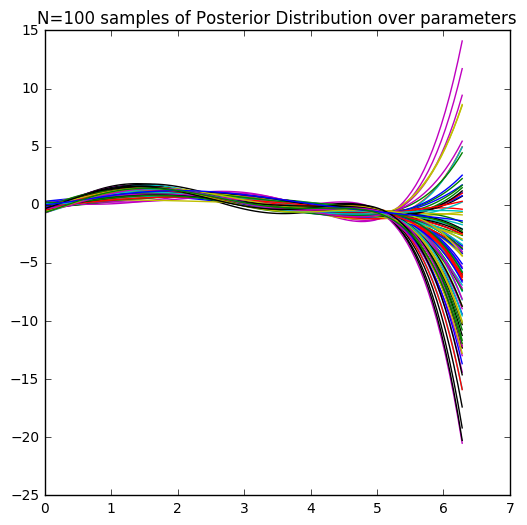

In [11]:
def predictive_plot():
    # a)

    # Generate initial dataset
    x, t = gen_sinusoidal2(7)
    M, alpha, beta = 5, 0.5, 25.

    # Sort values from smallest to biggest
    idx = np.argsort(x)
    x = x[idx]
    t = t[idx]

    # Obtain posterior mean and covariance
    posterior_mean, posterior_covariance = fit_polynomial_bayes(x, t, M, alpha, beta)

    # Sampling from 0 to 2pi
    samples = np.linspace(0, np.pi * 2, 100)

    # Predictive distribution for samples
    # Save mean and variance.
    sample_predictions = np.zeros(samples.shape)
    sample_variances = np.zeros(samples.shape)
    for index, val in enumerate(samples):
        y, v = predict_polynomial_bayes(val, posterior_mean, posterior_covariance, beta)
        sample_predictions[index] = y
        sample_variances[index] = v


    plt.figure(figsize=(8,4))
    plt.plot(x, t, 'bo')
    plt.plot(samples, sample_predictions, 'r', label='Fitted line')
    plt.fill_between(samples, sample_predictions + sample_variances, sample_predictions - sample_variances, alpha=0.1)
    plt.axis([-1,7,-2,4])
    plt.xlabel('x')
    plt.title('Point predictions with 68% confidence intervals')
    plt.ylabel('t')
    plt.grid(True)


    # b)
    fig = plt.figure(figsize=(6,6))
    Phi_pred = generate_dmatrix(samples,M)
    for i in range(100):
        w = np.random.multivariate_normal(posterior_mean.reshape(M+1,),posterior_covariance)
        plt.plot(samples,Phi_pred.dot(w))
    plt.title('N=100 samples of Posterior Distribution over parameters')

predictive_plot()

### 2.5 Additional questions (10 points)

a) (5 points) Why is $\beta=\frac{1}{0.2^2}$ the best choice of $\beta$ in section 2.4?

###### Solution
As we know the precision parameter $\beta = \frac{1}{sigma^2}$, it is the correct choice because it is the inverse of the variance associated with the noise of our sampling method. As we have $\sigma=0.2$, the optimal choice is $\beta=25$.



b) (5 points) In the case of Bayesian linear regression, both the posterior of the parameters $p(\bw \;|\; \bt, \alpha, \beta)$ and the predictive distribution $p(t \;|\; \bw, \beta)$ are Gaussian. In consequence (and conveniently), $p(t \;|\; \bt, \alpha, \beta)$ is also Gaussian (See Bishop's book section 3.3.2 and homework 2 question 4). This is actually one of the (rare) cases where we can make Bayesian predictions without resorting to approximative methods.

Suppose you have to work with some model $p(t\;|\;x,\bw)$ with parameters $\bw$, where the posterior distribution $p(\bw\;|\;\mathcal{D})$ given dataset $\mathcal{D}$ can not be integrated out when making predictions, but where you can still generate samples from the posterior distribution of the parameters. Explain how you can still make approximate Bayesian predictions using samples from the parameters' posterior distribution.

###### Solution
We use the same method from q2.4b (Monte Carlo sampling). In the absence of closed form solutions, by taking a large number of samples from the parameter's posterior distribution, we can make Bayesian predictions. The purpose is to provide an efficient method that uses averaging and randomness to make approximate predictions. Once we have drawn a large number of samples from the parameter's posterior distribution, we can compute means and confidence intervals to make predictions and quantify our certainty in them.